# Dataset Preprocessing

<br> ------------------------------------------------------------------------
<br> This notbeook is used to preprocess the dataset. 
<br> Perform the following steps to make use of the Lyft Lvl 5 Motion 
<br> Prediction Dataset for semantic map learning of traffic 
<br> light to lane assignment.
<br>
<br> tl2la
<br> Copyright (c) 2023 Andreas Weber. All Rights Reserved.
<br> ------------------------------------------------------------------------


In [3]:
import os
import sys
import subprocess
import warnings
import pandas as pd
from src.common.definitions import DATASET_TYPE
from src.dataset_operations.extended_map_api import ExtendedMapAPI
from src.common.helper import (init_dataset, load_from_pickled_file, save_as_pickled_file, reverse_dict_of_sets)
from src.dataset_operations.junction_dataset import JunctionDataset
from src.dataset_operations.preprocessing import (
                               generate_predecessor_successor_lookup,
                               generate_target_association,
                               generate_lane_tl_relation
                               )
from src.common.utils import filter_tl_scenes, get_ego_rect, get_lane_poly, visualize_mapping
from loguru import logger


# Ignore the RuntimeWarning for l5kit when loading zarr dataset
warnings.simplefilter(action='ignore', category=RuntimeWarning)

logger.remove()
logger_id = logger.add(sys.stderr, level="INFO")

In [5]:
# initalize required objects
dataset_type = "trainfull"
cfg, dm, zarr_dataset = init_dataset(config_name=dataset_type)

In [6]:
mapAPI = ExtendedMapAPI.from_config(dm, cfg)
junctionDataset = JunctionDataset(cfg, mapAPI, zarr_dataset)

### Cofigure Saving Dataset

In [8]:
# Set to true to store the preprocessed datasets to your file system
SAVE_DATASETS = False

### Filter recordings for traffic light scenes

In [13]:
tls_scene_indices = filter_tl_scenes(zarr_dataset)

# Save traffic light scenes to pickle file
save_path_tl_scenes = os.path.join("dataset", "preprocessed_info", "tls_scene_indices_trainfull.pkl")
if SAVE_DATASETS: save_as_pickled_file(save_path_tl_scenes, tls_scene_indices)


In [14]:
tls_scene_indices = load_from_pickled_file(save_path_tl_scenes)
print("First 10 scene indices, in which traffic lights occure:", tls_scene_indices[:10])

First 10 scene indices, in which traffic lights occure: [1, 2, 3, 4, 5, 6, 10, 11, 12, 13]


### Generation of Lookup Tables

#### Lane Graph: Predecessor and Successor Lookup

In [33]:
lanegraph_df = generate_predecessor_successor_lookup(mapAPI)

# Save Lanegraph
save_path_lane_graph = './dataset/preprocessed_info/lanegraph_df.pkl'
if SAVE_DATASETS: save_as_pickled_file(save_path_lane_graph, lanegraph_df)

In [35]:
tls_scene_indices = load_from_pickled_file(save_path_lane_graph)
tls_scene_indices[:10] # show the first 10 rows of the lane graph lookup table

,lane_id,predecessor,successor
0,362i,[UuoG],"[g/uY, Dn/N]"
1,TVqs,[5DSH],[tPZk]
2,kZV8,[wAqO],[a2yU]
3,ofbB,"[4ogT, IJIy]","[WgPD, jKbi]"
4,v7pb,[krBj],[VSpt]
5,/KHj,[MFfu],[we0x]
6,9GdD,[OUgn],[A8WX]
7,QNL+,"[SxLz, 9/ic, GvJ5]",[pp0]
8,v91x,"[htEt, aMf8]","[+hiT, o4kX, diiT, fD+t]"
9,U95I,[OKZw],"[A/xC, 7+yd]"


#### Semantic Relation: T2LA for all traffic light lane pairs

In [7]:
lane_tl_relations = generate_lane_tl_relation(mapAPI)
tl_lane_relations = reverse_dict_of_sets(lane_tl_relations)

### Ego Vehicle to Lane Mapping

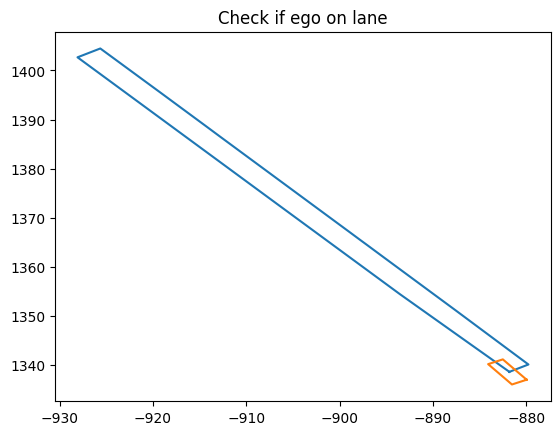

In [19]:
SCENE_IDX = 23
FRAME_IDX = 99
LANE_ID = "QtPT"

sample_scene = zarr_dataset.get_scene_dataset(SCENE_IDX)
ego_pos = sample_scene.frames[FRAME_IDX]["ego_translation"]
ego_rotation = sample_scene.frames[FRAME_IDX]["ego_rotation"]

 
ego_poly = get_ego_rect(ego_pos, ego_rotation)
lane_poly = get_lane_poly(LANE_ID, mapAPI)
visualize_mapping(ego_poly, lane_poly)

In [6]:
ego_lane_mapping = junctionDataset.get_frame_lane_ids(tls_scene_indices[:50])

Iterate through scenes to filter scenes by junctions:  40%|████      | 20/50 [00:03<00:06,  4.79it/s]

Mapping for Agent Pos: [-882.01647949 1338.5435791 ] was not possible in Scene: 23, Frame: 99!
Mapping for Agent Pos: [-882.55413818 1339.41479492] was not possible in Scene: 23, Frame: 100!
Mapping for Agent Pos: [-883.09509277 1340.27648926] was not possible in Scene: 23, Frame: 101!


Iterate through scenes to filter scenes by junctions: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


In [37]:
save_path_ego_lane_mapping = os.path.join("dataset", "preprocessed_info", "frame_lane_df_trainfull.pkl")
if SAVE_DATASETS: save_as_pickled_file(save_path_ego_lane_mapping, ego_lane_mapping)

In [39]:
ego_lane_mapping = load_from_pickled_file(save_path_ego_lane_mapping)
ego_lane_mapping[:10] # show the first 10 rows of the ego lane mapping dataset

,scene_idx,frame_idx,agent_id,lane_id
0,1,0,0,pcct
9,1,1,0,pcct
18,1,2,0,pcct
27,1,3,0,pcct
36,1,4,0,pcct
45,1,5,0,pcct
54,1,6,0,pcct
63,1,7,0,pcct
68,1,8,0,pcct
73,1,9,0,pcct


### All agents to Lane Mapping
Mapping all agents can take several hours, depending on hardware! Execute script in background by using screen might be useful

In [10]:
agent_lane_mapping_list = junctionDataset.map_agents_to_lanes(scene_idx=1)
agent_lane_mapping = pd.DataFrame(agent_lane_mapping_list, columns=["scene_idx", "frame_idx", "agent_id", "lane_ids"])
agent_lane_mapping

2023-08-14 21:18:39.241 | INFO     | src.JunctionDataset:map_agents_to_lanes:378 - Start mapping for Scene 1.
2023-08-14 21:18:39.246 | INFO     | src.JunctionDataset:map_agents_to_lanes:382 - Fetched Scene 1.
2023-08-14 21:18:40.845 | INFO     | src.JunctionDataset:map_agents_to_lanes:414 - Mapping for Scene 1 done.


,scene_idx,frame_idx,agent_id,lane_ids
0,1,0,0,[pcct]
1,1,0,1,[pcct]
2,1,0,0,[pcct]
3,1,0,1,[pcct]
4,1,0,2,"[ZN8y, QGVn]"
...,...,...,...,...
18498,1,248,946,[urF8]
18499,1,248,950,[udk+]
18500,1,248,956,[PrF8]
18501,1,248,960,[y4ms]


In [4]:
# Run agent lane mapping from notebook
os.environ["PYTHONPATH"]="."
subprocess.run(["../../venv_tl2la/bin/python", "scripts/preprocessing/agent_mapping.py"])

### Traffic Light Mapping

In [17]:
tl_status_list = junctionDataset.map_tl_status(scene_idx=1)
tl_status = pd.DataFrame(tl_status_list, columns=["scene_idx", "frame_idx", "tl_id", "tl_status", "active_faces", "inactive_faces", "unknown_faces"])
tl_status

2023-08-14 21:29:45.234 | INFO     | src.JunctionDataset:map_tl_status:431 - Start mapping for Scene 1.
2023-08-14 21:29:45.242 | INFO     | src.JunctionDataset:map_tl_status:435 - Fetched Scene 1.
2023-08-14 21:29:45.278 | INFO     | src.JunctionDataset:map_tl_status:461 - Mapping for Scene 1 done.


,scene_idx,frame_idx,tl_id,tl_status,active_faces,inactive_faces,unknown_faces
0,1,17,/ggb,4,[],[],"[CDDo, jutE, xbVG]"
1,1,18,/ggb,4,[],[],"[CDDo, jutE, xbVG]"
2,1,19,/ggb,4,[],[],"[CDDo, jutE, xbVG]"
3,1,19,NTTe,4,[],[],"[/NIJ, Q11q, xggH]"
4,1,20,/ggb,4,[],[],"[CDDo, jutE, xbVG]"
...,...,...,...,...,...,...,...
576,1,247,LL1i,0,[95kG],[],"[95kG, O5qn, vMJ3]"
577,1,247,NTTe,0,[/NIJ],[],"[/NIJ, Q11q, xggH]"
578,1,248,/ggb,0,[xbVG],[],"[CDDo, jutE]"
579,1,248,LL1i,0,[95kG],[],"[O5qn, vMJ3]"


In [18]:
# Run tl status mapping from notebook
os.environ["PYTHONPATH"]="."
subprocess.run(["../../venv_tl2la/bin/python", "scripts/preprocessing/tl_mapping.py"])

test


CompletedProcess(args=['../../venv_tl2la/bin/python', 'scripts/preprocessing/tl_mapping.py'], returncode=0)

### Derived Traffic Light States for a whole scene
Assumption that during a 25 second long scene, only one state change can occure. Therefore, an scene traffic light state can be derived: 
constant red, constant gree, red to green, green to red. unknown (in case of signal flicker)

In [ ]:
# Run tl status mapping from notebook
os.environ["PYTHONPATH"]="."
subprocess.run(["../../venv_tl2la/bin/python", "scripts/preprocessing/traffic_light_scene_state.py"])

### Agent motion dataset
Add vehicle kinemtatics (velocity, acceleration) to the dataset and store them to local filesystem

In [ ]:
# Run tl status mapping from notebook
os.environ["PYTHONPATH"]="."
subprocess.run(["../../venv_tl2la/bin/python", "scripts/preprocessing/agent_motion.py"])

### Combined Feature Dataset

Dataset containing all features to perform TL2LA. This includes mapping of agents to lane, vehicle kinematics, traffic light states, junction and branch information as well as additional features like traffic density on lane, distance towards stop line of junction, time elapsed since last state change was detected, etc.

In [ ]:
# Run tl status mapping from notebook
os.environ["PYTHONPATH"]="."
subprocess.run(["../../venv_tl2la/bin/python", "scripts/preprocessing/agent_features.py"])

### Ground Truth
Iterate through all scenes and check which traffic light has been detected by ego vehicles. The lane assignment of all visible traffic lights are then added to the ground truth dataset.

In [41]:
ground_truth = generate_target_association(mapAPI, junctionDataset)

save_path_gt = os.path.join("dataset", "preprocessed_info", "target_associations.pkl")
if SAVE_DATASETS: save_as_pickled_file(save_path_ego_lane_mapping, ground_truth)

In [42]:
ground_truth = load_from_pickled_file(save_path_gt)
ground_truth[:10] # show the first 10 rows of the gt dataset

,tl_id,lane_id,relation,junction_id,branch_id
0,/ggb,AxmM,1,y4Ss,Evy5c
1,/ggb,fxmM,1,y4Ss,Evy5c
2,/ggb,+xmM,1,y4Ss,Evy5c
3,NTTe,AxmM,1,y4Ss,Evy5c
4,NTTe,fxmM,1,y4Ss,Evy5c
5,NTTe,+xmM,1,y4Ss,Evy5c
6,LL1i,AxmM,0,y4Ss,Evy5c
7,LL1i,fxmM,0,y4Ss,Evy5c
8,LL1i,+xmM,1,y4Ss,Evy5c
9,3WL8,vLqW,0,3Ccg,S8XK4


## Given Dataset
1. Junction-Branch-Lane Dataset: Manually-labeled dataset that contains traffic light controlled junctions with its corrisponding branches and lane segments
   1. Extended: With all lane segments that correspond to a lane sequence (20m infront of an intersection)
   2. Minimal: With only the first lane segments that correspond to a lane sequence $\Rightarrow$ called sequence head lane id


In [21]:
minimal_junction_lane_ds = junctionDataset.get_branch_dataset(DATASET_TYPE.MINIMAL)
minimal_junction_lane_ds

,junction_id,branch_id,lane_id
0,RYcT,Sy2KY,8V6+
1,RYcT,Sy2KY,bW6+
2,RYcT,Sy2KY,6W6+
3,RYcT,NPJXi,5cF2
4,RYcT,NPJXi,YdF2
...,...,...,...
87,LrDx,NPYIq,eR/Y
88,LrDx,NPYIq,/Q/Y
89,LrDx,S4QRn,kgCj
90,LrDx,S4QRn,DhCj


In [22]:
minimal_junction_lane_ds = junctionDataset.get_branch_dataset(DATASET_TYPE.EXTENDED)
minimal_junction_lane_ds

,junction_id,branch_id,lane_id,lane_sequence_id,sequence_head_lane_id
0,RYcT,Sy2KY,lXo5,0,8V6+
1,RYcT,Sy2KY,8V6+,0,8V6+
2,RYcT,Sy2KY,bW6+,1,bW6+
3,RYcT,Sy2KY,EYo5,1,bW6+
4,RYcT,Sy2KY,6W6+,2,6W6+
...,...,...,...,...,...
367,LrDx,S4QRn,DhCj,117,DhCj
368,LrDx,S4QRn,bh2y,117,DhCj
369,LrDx,S4QRn,emZY,118,emZY
370,LrDx,S4QRn,qlr2,118,emZY
